In [15]:
from pySimFinLib import pySimFin
import matplotlib.pyplot as plt

psf = pySimFin()
aapl = psf.get_share_prices(['AAPL'],'2020-01-01','2024-01-01')

Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/simfin/load.py:154: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(path, sep=';', header=0,


Done!


In [16]:
aaplPrice = aapl['Open']
aaplPrice = aaplPrice.droplevel(level=0)

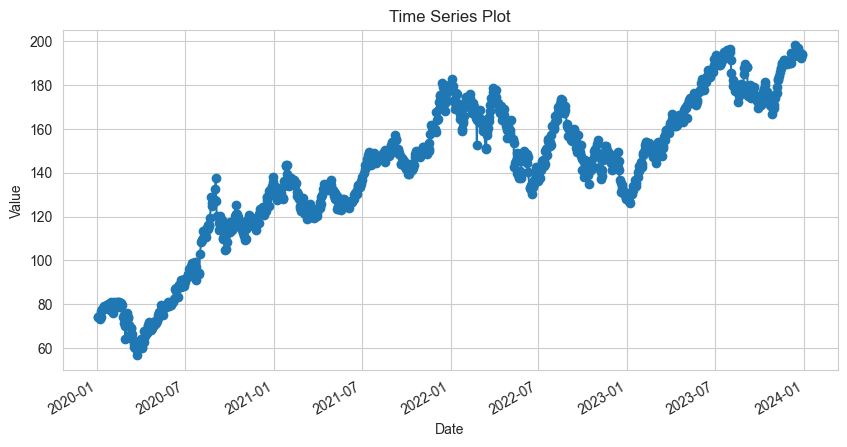

In [17]:
aaplPrice.plot(x='Date', y='Value', figsize=(10,5), marker='o', linestyle='-')

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Time Series Plot")

plt.show()